In [71]:
import sys, os
import argparse
import time
from types import SimpleNamespace


import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import faiss
import skimage.io as io

from dataset import CocoDataset, EmbedDataset
from utils import weight_init, collater, sec2str
from model import ImageEncoder, CaptionEncoder
from vocab import Vocabulary
from eval import retrieve_i2c, retrieve_c2i

In [75]:
path = "models/gru_bs128_101"
sorted(os.listdir(path))

['epoch_0001_score_00135.ckpt',
 'epoch_0002_score_00164.ckpt',
 'epoch_0003_score_00178.ckpt',
 'epoch_0004_score_00211.ckpt',
 'epoch_0005_score_00244.ckpt',
 'epoch_0006_score_00303.ckpt',
 'epoch_0007_score_00326.ckpt',
 'epoch_0008_score_00362.ckpt',
 'epoch_0009_score_00412.ckpt',
 'epoch_0010_score_00435.ckpt',
 'epoch_0011_score_00492.ckpt',
 'epoch_0012_score_00515.ckpt',
 'epoch_0013_score_00524.ckpt',
 'epoch_0014_score_00565.ckpt',
 'epoch_0015_score_00594.ckpt',
 'epoch_0016_score_00629.ckpt',
 'epoch_0017_score_00646.ckpt',
 'epoch_0018_score_00669.ckpt',
 'epoch_0019_score_00686.ckpt',
 'epoch_0020_score_00730.ckpt',
 'epoch_0021_score_00745.ckpt',
 'epoch_0022_score_00762.ckpt',
 'epoch_0023_score_00781.ckpt',
 'epoch_0024_score_00808.ckpt',
 'epoch_0025_score_00835.ckpt',
 'epoch_0027_score_00864.ckpt',
 'epoch_0028_score_00873.ckpt',
 'epoch_0029_score_00888.ckpt',
 'epoch_0030_score_00919.ckpt',
 'epoch_0032_score_00943.ckpt',
 'epoch_0033_score_00992.ckpt',
 'epoch_

In [77]:
def get_args():
    a = {
        "dataset": "coco",
        "checkpoint": os.path.join(path, "epoch_0076_score_01283.ckpt"),   # checkpoint from where to load model
        'root_path': '/groups1/gaa50131/datasets/MSCOCO',
        'vocab_path': 'captions_train2017.txt',
        'cnn_type': "resnet101",
        'rnn_type': "GRU",
        'emb_size': 512,
        'out_size': 512,
        'max_len': 30,
        'n_cpu': 8,
        'imsize': 224, 
        'batch_size': 128  
    }
    
    args = SimpleNamespace(**a)
    
    return args

args = get_args()

In [57]:
# transform if dataset is of images
transform = transforms.Compose([
    transforms.Resize((args.imsize, args.imsize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

if args.dataset == 'coco':
    val_dset = CocoDataset(root=args.root_path, imgdir='val2017', jsonfile='annotations/captions_val2017.json', transform=transform, mode='all')
val_loader = DataLoader(val_dset, batch_size=args.batch_size, shuffle=False, num_workers=args.n_cpu, collate_fn=collater)
vocab = Vocabulary(max_len=args.max_len)
vocab.load_vocab(args.vocab_path)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
building vocabulary...
done building vocabulary, minimum frequency is 5 times
# of words in vocab: 10210 | elapsed: 32s


In [78]:
imenc = ImageEncoder(out_size=args.out_size, cnn_type=args.cnn_type)
capenc = CaptionEncoder(vocab_size=len(vocab), emb_size=args.emb_size, out_size=args.out_size, rnn_type=args.rnn_type, padidx=vocab.padidx)
device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")

assert args.checkpoint is not None
print("loading model checkpoint from {}".format(args.checkpoint))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt = torch.load(args.checkpoint, map_location=device)
imenc.load_state_dict(ckpt["encoder_state"])
capenc.load_state_dict(ckpt["decoder_state"])

begin = time.time()
print("creating database")
dset = EmbedDataset(val_loader, imenc, capenc, vocab, args)
print("database created | {}".format(sec2str(time.time()-begin)))

loading model checkpoint from models/gru_bs128_101/epoch_0076_score_01283.ckpt
creating database
database created | elapsed: 02m47s


--------------------------------------------------


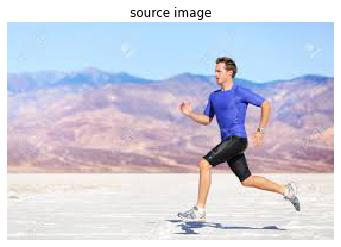

# captions: 25000, dimension: 512
retrieval time elapsed: 00s
--------------------------------------------------
20 nearest neighbors of image:
A slice of cake and a fork by sliced orange and a Guinness 
A man sits on a park bench surrounded by pigeons
a small bird sits on top of a book page 
A church tower with a clock in the centre and arched windows
a plane with the attachment to let passengers on the plane 
a tennis player sitting in a chair shirtless
Not the biggest workspace in the world, but it works
a small stereo a banana and a flashlight
Two men in neon yellow safety jackets sharing a meal next to a food car.
A man rides with a child on a motorcycle down a busy street with other pedestrians and bicyclists
a lady operating a video camera in a computer class
A clean kitchen with all the necessary appliances.
a long table with many containers of food on it and many people around it
The antique bed has elaborate wood decoration on the frame..
A yellow and a green motorcycle in th

In [80]:
%matplotlib inline
retrieve_i2c(dset, val_dset, "samples/sample1.jpg", imenc, transform, k=20)

--------------------------------------------------
source caption: 'bat'
# images: 5000, dimension: 512
retrieval time elapsed: 00s
--------------------------------------------------
5 nearest neighbors of 'bat'


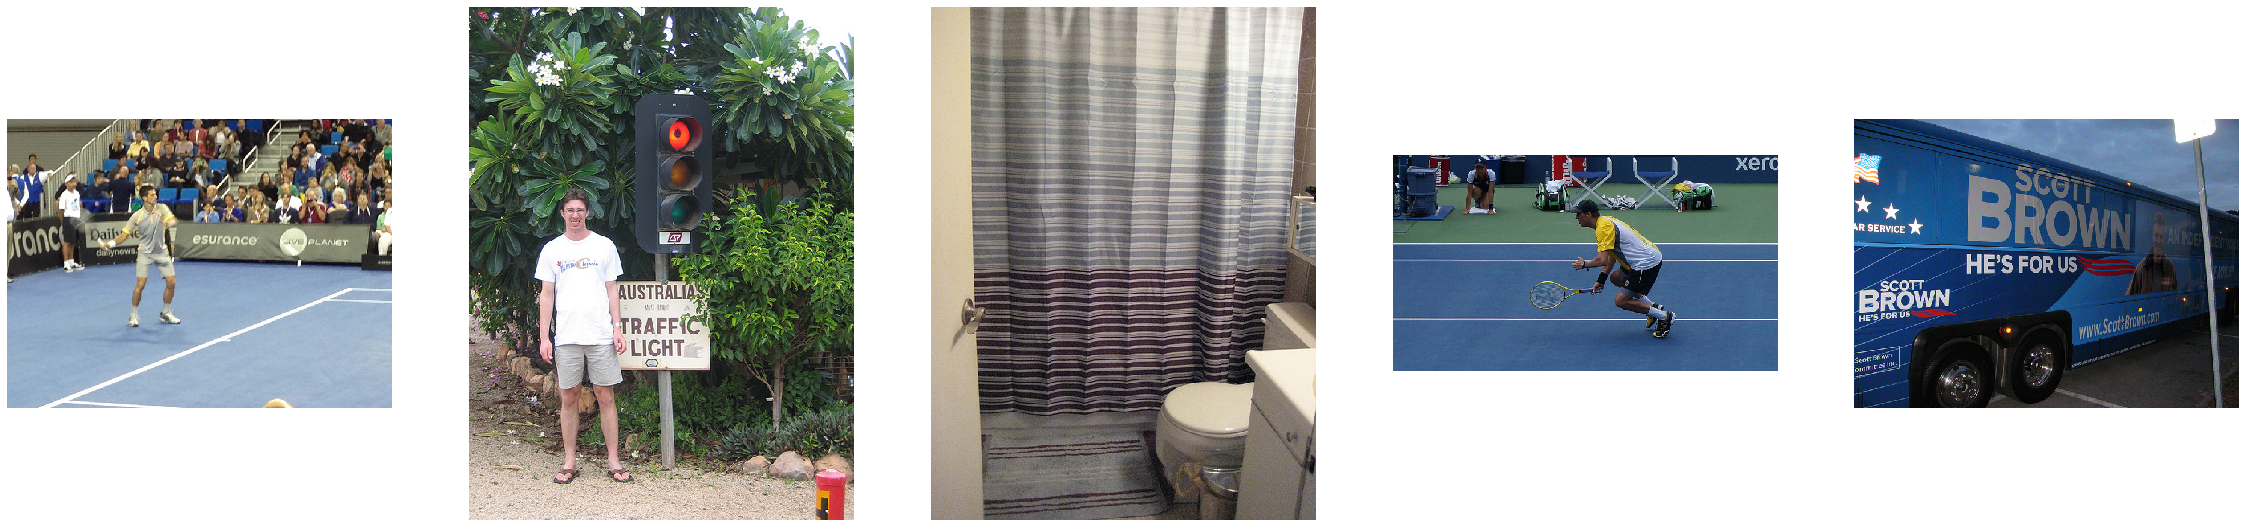

--------------------------------------------------


In [88]:
%matplotlib inline
caption = "bat"
retrieve_c2i(dset, val_dset, caption, capenc, vocab, k=5)